This notebook fits a topic model to the Sherlock text descriptions and then transformed the recall transcripts with the model.

## Import libraries

In [10]:
import pandas as pd
import hypertools as hyp
import numpy as np
from scipy.spatial.distance import cdist
from scipy.signal import resample
from scipy import ndimage
from scipy.stats import zscore
from skimage.transform import resize
from fastdtw import fastdtw
from scipy.spatial.distance import correlation
import seaborn as sns

%matplotlib inline


def _z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation

    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value

    Returns
    ----------
    result : int or ndarray
        Correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))


## Set data paths

In [5]:
rawdir = '../../../data/raw/' 
datadir = '../../../data/processed/'

## Set model parameters

In [42]:
video_wsize = 50
n_topics = 100
recall_wsize = 10

## Load data and forward fill the segment labels

In [43]:
video_text = pd.read_excel(rawdir+'Sherlock_Segments_1000_NN_2017.xlsx')
video_text['Scene Segments'].fillna(method='ffill', inplace=True)

## Fit topic model to manually-annotated movie

In [44]:
# create a list of text samples from the scene descriptions / details to train the topic model
video = video_text.loc[:,'Scene Details - A Level ':'Words on Screen '].apply(lambda x: ', '.join(x.fillna('')), axis=1).values.tolist()

# create a list of overlapping text samples
video_w = []
for idx, sentence in enumerate(video):
    video_w.append(','.join(video[idx:idx+video_wsize]))

# vectorizer parameters
vectorizer = {
    'model' : 'CountVectorizer', 
    'params' : {
        'stop_words' : 'english'
    }
}

# topic model parameters
semantic = {
    'model' : 'LatentDirichletAllocation', 
    'params' : {
        'n_components' : n_topics,
        'learning_method' : 'batch',
        'random_state' : 0,
    }
}

# create video model with hypertools
video_model = hyp.tools.format_data(video_w, vectorizer=vectorizer, semantic=semantic, corpus=video_w)[0]

# description are by scene, not TR so stretch the model to be in TRs
ranges =[[d['Start Time (TRs, 1.5s)'],d['End Time (TRs, 1.5s)']] for i, d in video_text.iterrows()] 
expanded = []
for i in range(1976):
    try:
        idx = np.where([i>=r[0] and i<=r[1] for r in ranges])[0][0]
        expanded.append(video_model[idx, :])
    except:
        expanded.append(video_model[0, :])
video_model = np.array(expanded)

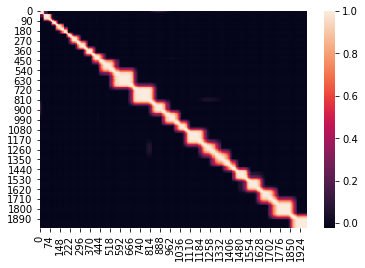

In [45]:
sns.heatmap(1 - cdist(video_model, video_model, 'correlation'))

## Transform recalls

In [46]:
# loop over subjects
recall_w = []
for sub in range(1, 18):
    
    # load subject data
    recall = pd.read_csv(rawdir+'NN'+str(sub)+' transcript.txt', header=None, sep='.', error_bad_lines=False, encoding='latin-1').values.tolist()[0][:-1]
    
    rs = []  
    # loop over sentences
    for sentence in recall:
        try:
            s = sentence.encode('utf-8').strip()
            rs.append(sentence)
        except:
            pass # skips over nans
    
    # create overlapping windows of n sentences
    sub_recall_w = []
    for idx, sentence in enumerate(rs):
        sub_recall_w.append(','.join(rs[idx:idx+recall_wsize]))
        
    recall_w.append(sub_recall_w)
    
# create recall models
recall_models = hyp.tools.format_data(recall_w, vectorizer=vectorizer, semantic=semantic, corpus=video_w)

# resample the models
recall_models_rs = list(map(lambda x: resample(x, 1976), recall_models))

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

## Save video and recall models

In [48]:
np.save(datadir+'models_t%s_v%s_r%s' % (str(n_topics), str(video_wsize), str(recall_wsize)), [video_model, recall_models])
np.save(datadir+'models_t%s_v%s_r%s_resampled' % (str(n_topics), str(video_wsize), str(recall_wsize)), [video_model, recall_models_rs])